In [74]:
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from os import listdir

sns.set(
    font="ABC Sans Nova"
)

metadata = pd.read_excel(
    "./metadata.xlsx",
    sheet_name=1,
    header=10
)

file_names = listdir("./census_data")
file_names = sorted([file_name for file_name in file_names if ".csv" in file_name])

for i, file_name in enumerate(file_names):
    
    key = file_name.split("_")[1]
    
    file_data = pd.read_csv(
        f"./census_data/{file_name}",
        index_col="SAL_CODE_2021"
    )
    
    file_data.columns = [
        metadata[
            (metadata.DataPackfile == key) &
            (metadata.Short == string)
        ].iat[0, 2].lower() for string in file_data.columns
    ]
            
    if i == 0:
        suburb_data = file_data
    
    else:        
        suburb_data = suburb_data.join(
            file_data,
            lsuffix=f"_v{i}"
        )

suburb_data.to_csv("./raw_suburb_data.csv")

act_suburbs = pd.read_csv(
    "./act_suburbs.csv"
)
act_suburbs.code = "SAL" + act_suburbs.code.astype("str")

In [75]:
data = pd.DataFrame(
    index=act_suburbs.code,
    data={
        "name": act_suburbs.name.to_list(),
        "belco":  act_suburbs.belco.to_list()
    }
)

data["population"] = suburb_data.total_persons_persons
data["dwellings"] = suburb_data.total_dwellings
data = data[data.population >= 30]
suburb_data = suburb_data.loc[data.index]

data["masculinity"] = suburb_data.total_persons_males / data.population
data["age_under_5"] = suburb_data.age_groups_0_4_years_persons / data.population
data["age_under_15"] = suburb_data.age_groups_5_14_years_persons / data.population + data.age_under_5
data["age_under_20"] = suburb_data.age_groups_15_19_years_persons / data.population + data.age_under_15
data["age_under_25"] = suburb_data.age_groups_20_24_years_persons / data.population + data.age_under_20
data["age_under_35"] = suburb_data.age_groups_25_34_years_persons / data.population + data.age_under_25
data["age_under_45"] = suburb_data.age_groups_35_44_years_persons / data.population + data.age_under_35
data["age_under_55"] = suburb_data.age_groups_45_54_years_persons / data.population + data.age_under_45
data["age_under_65"] = suburb_data.age_groups_55_64_years_persons / data.population + data.age_under_55
data["age_under_75"] = suburb_data.age_groups_65_74_years_persons / data.population + data.age_under_65
data["age_under_85"] = suburb_data.age_groups_75_84_years_persons / data.population + data.age_under_75
data["indigenous"] = suburb_data.aboriginal_and_or_torres_strait_islander_persons_total_persons / data.population
data["born_overseas"] = suburb_data.birthplace_elsewhere_persons / data.population
data["other_language"] = suburb_data.language_used_at_home_other_language_persons / data.population
data["citizens"] = suburb_data.australian_citizen_persons / data.population
data["median_age"] = suburb_data.median_age_of_persons
data["median_mortgage_repayment"] = suburb_data.median_mortgage_repayment_monthly
data["median_personal_income"] = suburb_data.median_total_personal_income_weekly
data["median_rent"] = suburb_data.median_rent_weekly
data["median_family_income"] = suburb_data.median_total_family_income_weekly
data["avg_people_bedroom"] = suburb_data.average_number_of_persons_per_bedroom
data["median_household_income"] = suburb_data.median_total_household_income_weekly
data["avg_household_size"] = suburb_data.average_household_size
data["marriage_divorce_ratio"] = suburb_data.persons_total_married / suburb_data.persons_total_divorced
data["australian_parents"] = suburb_data.australian_both_parents_born_in_australia / data.population

countries = [
    ["afghanistan"],
    ["bangladesh"],
    ["bosnia and herzegovina"],
    ["brazil"],
    ["cambodia"],
    ["canada"],
    ["chile"],
    ["china", "china excludes sars and taiwan"],
    ["croatia"],
    ["egypt"],
    ["england"],
    ["egypt"],
    ["fiji"],
    ["france"],
    ["germany"],
    ["greece"],
    ["hong kong", "hong kong sar of china"],
    ["india"],
    ["indonesia"],
    ["iran"],
    ["iraq"],
    ["ireland"],
    ["italy"],
    ["japan"],
    ["korea", "korea republic of south"],
    ["lebanon"],
    ["malaysia"],
    ["malta"],
    ["mauritius"],
    ["myanmar"],
    ["nepal"],
    ["netherlands"],
    ["new zealand"],
    ["north macedonia"],
    ["pakistan"],
    ["papua new guinea"],
    ["philippines"],
    ["poland"],
    ["samoa"],
    ["scotland"],
    ["singapore"],
    ["south africa"],
    ["sri lanka"],
    ["taiwan"],
    ["thailand"],
    ["turkey"],
    ["usa", "united states of america"],
    ["vietnam"],
    ["wales"],
    ["zimbabwe"]
]

for country in countries:
    if len(country) == 1:
        string = country[0].replace(" ", "_")
    else:
        string = country[1].replace(" ", "_")
    try:
        data[f"{country[0].replace(' ', '_')}_born"] = suburb_data[f"persons_{string}_total"] / data.population
    except:
        data[f"{country[0].replace(' ', '_')}_born"] = suburb_data[f"persons_{string}_age_total"] / data.population

data["buddhism"] = suburb_data.buddhism_persons / data.population
data["christianity"] = suburb_data.christianity_total_persons / data.population
data["hinduism"] = suburb_data.hinduism_persons / data.population
data["islam"] = suburb_data.islam_persons / data.population
data["judaism"] = suburb_data.judaism_persons / data.population
data["secular"] = suburb_data.secular_beliefs_and_other_spiritual_beliefs_and_no_religious_affiliation_total_persons / data.population
data["public_school_primary"] = suburb_data.primary_government_persons / suburb_data.primary_total_primary_persons
data["public_school_secondary"] = suburb_data.secondary_government_persons / suburb_data.secondary_total_secondary_persons
data["vet_students"] = suburb_data.tertiary_vocational_education_including_tafe_and_private_training_providers_full_time_student_aged_15_24_years_persons / (suburb_data.age_groups_15_19_years_persons + suburb_data.age_groups_20_24_years_persons)
data["uni_students"] = suburb_data.tertiary_university_or_other_higher_education_full_time_student_aged_15_24_years_persons / (suburb_data.age_groups_15_19_years_persons + suburb_data.age_groups_20_24_years_persons)
data["personal_income_nil"] = suburb_data.persons_negative_nil_income_total / suburb_data.persons_total_total_v38
data["personal_income_under_150"] = suburb_data.persons_1_149_total / suburb_data.persons_total_total_v38 + data.personal_income_nil
data["personal_income_under_300"] = suburb_data.persons_150_299_total / suburb_data.persons_total_total_v38 + data.personal_income_under_150
data["personal_income_under_400"] = suburb_data.persons_300_399_total / suburb_data.persons_total_total_v38 + data.personal_income_under_300
data["personal_income_under_500"] = suburb_data.persons_400_499_total / suburb_data.persons_total_total_v38 + data.personal_income_under_400
data["personal_income_under_650"] = suburb_data.persons_500_649_total / suburb_data.persons_total_total_v38 + data.personal_income_under_500
data["personal_income_under_800"] = suburb_data.persons_650_799_total / suburb_data.persons_total_total_v38 + data.personal_income_under_650
data["personal_income_under_1000"] = suburb_data.persons_800_999_total / suburb_data.persons_total_total_v38 + data.personal_income_under_800
data["personal_income_under_1250"] = suburb_data.persons_1000_1249_total / suburb_data.persons_total_total_v38 + data.personal_income_under_1000
data["personal_income_under_1500"] = suburb_data.persons_1250_1499_total / suburb_data.persons_total_total_v38 + data.personal_income_under_1250
data["personal_income_under_1750"] = suburb_data.persons_1500_1749_total / suburb_data.persons_total_total_v38 + data.personal_income_under_1500
data["personal_income_under_2000"] = suburb_data.persons_1750_1999_total / suburb_data.persons_total_total_v38 + data.personal_income_under_1750
data["personal_income_under_3000"] = suburb_data.persons_2000_2999_more_total / suburb_data.persons_total_total_v38 + data.personal_income_under_2000
data["personal_income_under_3500"] = suburb_data.persons_3000_3499_total / suburb_data.persons_total_total_v38 + data.personal_income_under_3000
data["needs_assistance"] = suburb_data.persons_total_has_need_for_assistance / data.population
data["arthritis"] = suburb_data.persons_arthritis_age_total_responses / data.population
data["asthma"] = suburb_data.persons_asthma_age_total_responses / data.population
data["cancer"] = suburb_data.persons_cancer_including_remission_age_total_responses / data.population
data["dementia"] = suburb_data.persons_dementia_including_alzheimers_age_total_responses / data.population
data["diabetes"] = suburb_data.persons_diabetes_excluding_gestational_diabetes_age_total_responses / data.population
data["heart_disease"] = suburb_data.persons_heart_disease_including_heart_attack_or_angina_age_total_responses / data.population
data["kidney_disease"] = suburb_data.persons_kidney_disease_age_total_responses / data.population
data["lung_condition"] = suburb_data.persons_lung_condition_including_copd_or_emphysema_age_total_responses / data.population
data["mental_illness"] = suburb_data.persons_mental_health_condition_including_depression_or_anxiety_age_total_responses / data.population
data["stroke"] = suburb_data.persons_stroke_age_total_responses / data.population
data["healthy"] = suburb_data.persons_no_long_term_health_conditions_age_total_responses / data.population
data["military"] = suburb_data.persons_has_served_in_the_australian_defence_total_ever_served_age_total / data.population
data["volunteer"] = suburb_data.persons_total_volunteer / data.population
data["lone_parent"] = suburb_data.persons_lone_parent_total / data.population
data["group_house"] = suburb_data.persons_group_household_member_total / data.population
data["group_house"] = suburb_data.persons_group_household_member_total / data.population
data["household_income_nil"] = suburb_data.negative_nil_income_total_v108 / data.dwellings
data["household_income_under_150"] = suburb_data["1_149_total_v108"] / data.dwellings + data.household_income_nil
data["household_income_under_300"] = suburb_data["150_299_total_v67"] / data.dwellings + data.household_income_under_150
data["household_income_under_400"] = suburb_data["300_399_total_v108"] / data.dwellings + data.household_income_under_300
data["household_income_under_500"] = suburb_data["400_499_total_v108"] / data.dwellings + data.household_income_under_400
data["household_income_under_650"] = suburb_data["500_649_total_v108"] / data.dwellings + data.household_income_under_500
data["household_income_under_800"] = suburb_data["650_799_total_v108"] / data.dwellings + data.household_income_under_650
data["household_income_under_1000"] = suburb_data["800_999_total_v66"] / data.dwellings + data.household_income_under_800
data["household_income_under_1250"] = suburb_data["1000_1249_total_v108"] / data.dwellings + data.household_income_under_1000
data["household_income_under_1500"] = suburb_data["1250_1499_total_v108"] / data.dwellings + data.household_income_under_1250
data["household_income_under_1750"] = suburb_data["1500_1749_total_v108"] / data.dwellings + data.household_income_under_1500
data["household_income_under_2000"] = suburb_data["1750_1999_total_v108"] / data.dwellings + data.household_income_under_1750
data["household_income_under_2500"] = suburb_data["2000_2499_total_v108"] / data.dwellings + data.household_income_under_2000
data["household_income_under_3000"] = suburb_data["2500_2999_total_v108"] / data.dwellings + data.household_income_under_2500
data["household_income_under_3500"] = suburb_data["3000_3499_total_v108"] / data.dwellings + data.household_income_under_3000
data["household_income_under_4000"] = suburb_data["3500_3999_total_v108"] / data.dwellings + data.household_income_under_3500
data["cars_nil"] = suburb_data.number_of_motor_vehicles_per_dwelling_no_motor_vehicles_dwellings / data.dwellings
data["cars_under_2"] = suburb_data.number_of_motor_vehicles_per_dwelling_one_motor_vehicle_dwellings / data.dwellings + data.cars_nil
data["cars_under_3"] = suburb_data.number_of_motor_vehicles_per_dwelling_two_motor_vehicles_dwellings / data.dwellings + data.cars_under_2
data["cars_under_4"] = suburb_data.number_of_motor_vehicles_per_dwelling_three_motor_vehicles_dwellings / data.dwellings + data.cars_under_3
data["houses"] = suburb_data.total_dwelling_structure_separate_house_v66 / suburb_data.total_total_v66
data["semidetached"] = suburb_data.total_dwelling_structure_semi_detached_row_or_terrace_house_townhouse_etc_v66 / suburb_data.total_total_v66
data["units"] = suburb_data.total_dwelling_structure_flat_or_apartment_v66 / suburb_data.total_total_v66
data["owned_outright"] = suburb_data.owned_outright_total / suburb_data.total_total_v66
data["mortgaged"] = suburb_data.owned_with_a_mortgage_total / suburb_data.total_total_v66
data["rented"] = suburb_data.rented_total_total / suburb_data.total_total_v66
data["unemployed"] = suburb_data.labour_force_status_percent_unemployment_persons / 100
data["postgrads"] = suburb_data.highest_non_school_qualifications_postgraduate_degree_level_persons / suburb_data.persons_aged_15_years_and_over_persons
data["graduates"] = (suburb_data.highest_non_school_qualifications_postgraduate_degree_level_persons + suburb_data.highest_non_school_qualifications_graduate_diploma_and_graduate_certificate_level_persons + suburb_data.highest_non_school_qualifications_bachelor_degree_level_persons) / suburb_data.persons_aged_15_years_and_over_persons
data["mobility_5_years"] = suburb_data.migration_lived_at_different_address_5_years_ago_persons / (data.population - data.age_under_5)
data["job_managers"] = suburb_data.persons_total_occupation_managers_v94 / suburb_data.persons_total_total_v94
data["job_professionals"] = suburb_data.persons_total_occupation_professionals_v94 / suburb_data.persons_total_total_v94
data["job_trades"] = suburb_data.persons_total_occupation_technicians_and_trades_workers_v94 / suburb_data.persons_total_total_v94
data["job_community"] = suburb_data.persons_total_occupation_community_and_personal_service_workers_v94 / suburb_data.persons_total_total_v94
data["job_clerical"] = suburb_data.persons_total_occupation_clerical_and_administrative_workers_v94 / suburb_data.persons_total_total_v94
data["job_sales"] = suburb_data.persons_total_occupation_sales_workers_v94 / suburb_data.persons_total_total_v94
data["job_drivers"] = suburb_data.persons_total_occupation_machinery_operators_and_drivers_v94 / suburb_data.persons_total_total_v94
data["job_labourers"] = suburb_data.persons_total_occupation_labourers_v94 / suburb_data.persons_total_total_v94
data["industry_agriculture"] = suburb_data.persons_agriculture_forestry_and_fishing_total_v104 / suburb_data.persons_total_total_v105
data["industry_mining"] = suburb_data.persons_mining_total_v104 / suburb_data.persons_total_total_v105
data["industry_manufacturing"] = suburb_data.persons_manufacturing_total_v104 / suburb_data.persons_total_total_v105
data["industry_utilities"] = suburb_data.persons_electricity_gas_water_and_waste_services_total_v104 / suburb_data.persons_total_total_v105
data["industry_construction"] = suburb_data.persons_construction_total_v104 / suburb_data.persons_total_total_v105
data["industry_wholesale"] = suburb_data.persons_wholesale_trade_total_v104 / suburb_data.persons_total_total_v105
data["industry_retail"] = suburb_data.persons_retail_trade_total_v104 / suburb_data.persons_total_total_v105
data["industry_hospitality"] = suburb_data.persons_accommodation_and_food_services_total_v104 / suburb_data.persons_total_total_v105
data["industry_logistics"] = suburb_data.persons_transport_postal_and_warehousing_total_v104 / suburb_data.persons_total_total_v105
data["industry_technology"] = suburb_data.persons_information_media_and_telecommunications_total_v104 / suburb_data.persons_total_total_v105
data["industry_finance"] = suburb_data.persons_financial_and_insurance_services_total_v104 / suburb_data.persons_total_total_v105
data["industry_property"] = suburb_data.persons_rental_hiring_and_real_estate_services_total_v104 / suburb_data.persons_total_total_v105
data["industry_scientific"] = suburb_data.persons_professional_scientific_and_technical_services_total_v104 / suburb_data.persons_total_total_v105
data["industry_administration"] = suburb_data.persons_administrative_and_support_services_total_v104 / suburb_data.persons_total_total_v105
data["industry_government"] = suburb_data.persons_public_administration_and_safety_total_v104 / suburb_data.persons_total_total_v105
data["industry_education"] = suburb_data.persons_education_and_training_total_v104 / suburb_data.persons_total_total_v105
data["industry_health"] = suburb_data.persons_health_care_and_social_assistance_total_v104 / suburb_data.persons_total_total_v105
data["industry_arts"] = suburb_data.persons_arts_and_recreation_services_total_v104 / suburb_data.persons_total_total_v105

data = data.loc[data.isna().sum(axis=1) == 0]
data 

/tmp/ipykernel_261132/4125121436.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["needs_assistance"] = suburb_data.persons_total_has_need_for_assistance / data.population
/tmp/ipykernel_261132/4125121436.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["arthritis"] = suburb_data.persons_arthritis_age_total_responses / data.population
/tmp/ipykernel_261132/4125121436.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

,name,belco,population,dwellings,masculinity,age_under_5,age_under_15,age_under_20,age_under_25,age_under_35,...,industry_logistics,industry_technology,industry_finance,industry_property,industry_scientific,industry_administration,industry_government,industry_education,industry_health,industry_arts
code,,,,,,,,,,,,,,,,,,,,,
SAL80018,Ainslie,0,5376,2018,0.471726,0.048549,0.166481,0.221726,0.294457,0.406622,...,0.008227,0.020942,0.017203,0.008227,0.133134,0.026552,0.336200,0.122663,0.077412,0.028796
SAL80019,Amaroo,0,6129,2039,0.495676,0.060858,0.226138,0.305760,0.370370,0.498287,...,0.021170,0.016760,0.015584,0.009703,0.101735,0.026169,0.312849,0.083505,0.092032,0.016172
SAL80020,Aranda,1,2605,897,0.487524,0.054511,0.196929,0.251440,0.314395,0.418042,...,0.009946,0.015302,0.011477,0.016832,0.136955,0.021423,0.294568,0.144606,0.091813,0.029074
SAL80021,Banks,0,5100,1772,0.499020,0.062549,0.212353,0.280588,0.349412,0.497255,...,0.042867,0.016075,0.011386,0.014066,0.062960,0.028801,0.282652,0.061956,0.108841,0.014401
SAL80022,Barton,0,1946,943,0.489723,0.027749,0.073484,0.093525,0.159301,0.425488,...,0.009685,0.012914,0.014528,0.019370,0.141243,0.004843,0.531881,0.075868,0.062147,0.010492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAL80131,Watson,0,6727,2658,0.484466,0.065408,0.199792,0.246767,0.313215,0.502453,...,0.012690,0.023604,0.011168,0.009391,0.126396,0.031726,0.318020,0.123096,0.097208,0.030711
SAL80132,Weetangera,1,2795,930,0.499106,0.046512,0.184258,0.260107,0.318068,0.419678,...,0.018921,0.012614,0.022425,0.011212,0.135249,0.018921,0.278907,0.135249,0.104415,0.025228
SAL80133,Weston,0,4000,1469,0.483250,0.057000,0.189500,0.241500,0.288500,0.393500,...,0.016816,0.019443,0.019968,0.011561,0.118234,0.027325,0.316343,0.105623,0.124015,0.019968


<AxesSubplot: xlabel='industry_government', ylabel='Count'>

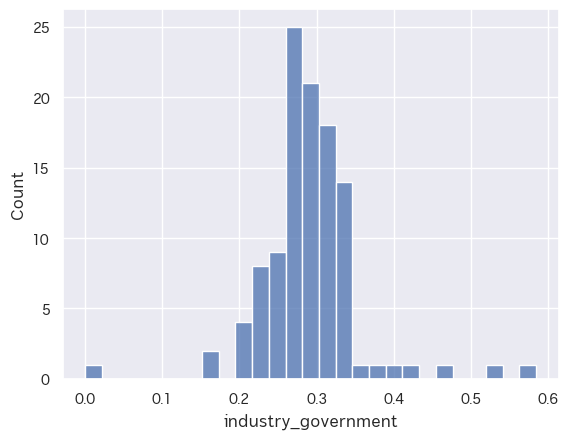

In [76]:
sns.histplot(data.industry_government)

<AxesSubplot: xlabel='no_features', ylabel='accuracy'>

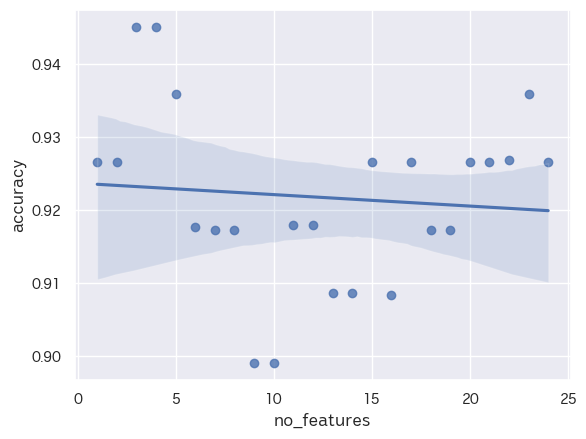

In [77]:
X = data.iloc[:, 3:]
y = data.loc[:, "belco"]

mi_scores = pd.Series(
    index=X.columns,
    data=mutual_info_classif(X, y)
).sort_values(ascending=False)

mi_scores.head(50)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(n_jobs=4))
])

# X.iloc[:, selector.get_support(indices=True)]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25
)

results = pd.DataFrame(columns=["no_features", "accuracy"])

for k in np.arange(1, 25):

    selector = SelectKBest(
        mutual_info_classif,
        k=k
    )

    X_reduced = selector.fit_transform(X, y)

    scores = cross_val_score(
        clf,
        X_reduced, y,
        cv=4
    )
    results.loc[len(results)] = [k, scores.mean()]
    

sns.regplot(
    data=results,
    x="no_features",
    y="accuracy"
)


In [ ]:
chart_data = data.copy()
chart_data.belco = chart_data.belco.astype("str")

for feature in mi_scores[mi_scores > .02].index:

    sns.catplot(
        data=chart_data,
        x=feature,
        y="belco",
        kind="boxen",
        hue="belco"
    )
    plt.show()

In [84]:
mi_scores[mi_scores > 0].head(50)

south_africa_born              0.098176
industry_education             0.087502
avg_household_size             0.079576
age_under_5                    0.074780
personal_income_under_150      0.068240
mobility_5_years               0.063897
dementia                       0.061146
industry_property              0.060359
ireland_born                   0.051408
thailand_born                  0.045282
age_under_15                   0.043973
age_under_85                   0.041439
median_rent                    0.041238
buddhism                       0.040169
vietnam_born                   0.039759
age_under_75                   0.037979
judaism                        0.037960
industry_construction          0.037509
personal_income_under_1000     0.036469
pakistan_born                  0.036113
singapore_born                 0.035782
industry_manufacturing         0.035639
age_under_45                   0.034724
china_born                     0.034706
age_under_20                   0.033148


In [71]:
suburb_data.columns.tolist()[14000:]

['persons_wholesale_trade_total_v100',
 'persons_retail_trade_postgraduate_degree_level',
 'persons_retail_trade_graduate_diploma_and_graduate_certificate_level',
 'persons_retail_trade_bachelor_degree_level',
 'persons_retail_trade_advanced_diploma_and_diploma_level',
 'persons_retail_trade_certificate_level',
 'persons_retail_trade_inadequately_described_not_stated',
 'persons_retail_trade_total_v100',
 'persons_accommodation_and_food_services_postgraduate_degree_level',
 'persons_accommodation_and_food_services_graduate_diploma_and_graduate_certificate_level',
 'persons_accommodation_and_food_services_bachelor_degree_level',
 'persons_accommodation_and_food_services_advanced_diploma_and_diploma_level',
 'persons_accommodation_and_food_services_certificate_level',
 'persons_accommodation_and_food_services_inadequately_described_not_stated',
 'persons_accommodation_and_food_services_total_v100',
 'persons_transport_postal_and_warehousing_postgraduate_degree_level',
 'persons_transport